In [23]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [24]:
env = BlackjackEnv()

In [25]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [30]:
def create_greedy_policy(Q):
    def policy_fn(observation):
        A = np.zeros_like(Q[observation], dtype=float)
        best_a = np.argmax(Q[observation])
        A[best_a] = 1.0
        return A
    return policy_fn

In [34]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))

    target_policy = create_greedy_policy(Q)
    gamma = discount_factor
    
    for episode in range(1, num_episodes + 1):

        episodes = []
        s = env.reset()
        done = False
        while done == False:
            p = behavior_policy(s)
            a = np.random.choice(np.arange(len(p)), p=p)
            future_s, r, done, _ = env.step(a)
            episodes.append((s, a, r))
            state = future_s
        
        G = 0.0
        V = 1.0

        for t in range(len(episodes))[::-1]:
            state, a, r = episodes[t]
            G = gamma * G + r
            C[s][a] += V
            Q[s][a] += (V / C[s][a]) * (G - Q[s][a])
            if a !=  np.argmax(target_policy(s)):
                break
            V = V * 1./behavior_policy(s)[a]
    return Q, target_policy

In [35]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

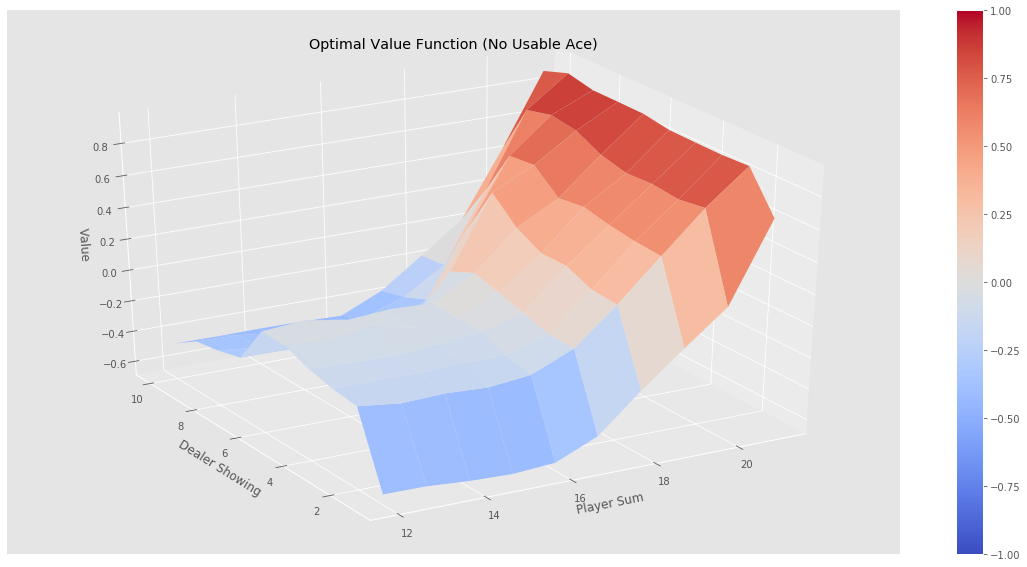

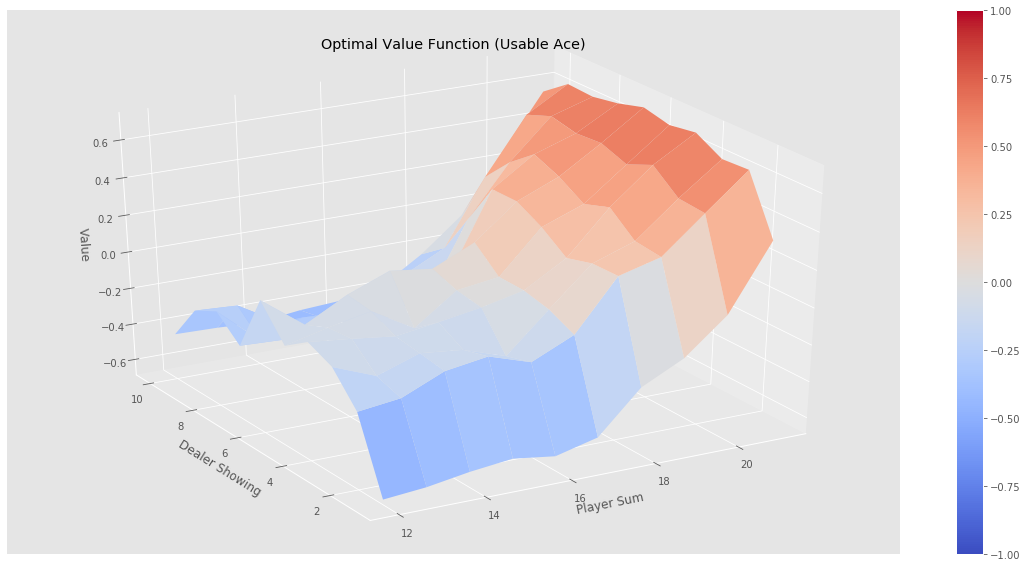

In [36]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")